## Data preprocessing
- Reading in
- Creating Average Coulumn of Oil,Gas,Dry as Drill
- Creating pct_change() column for the new Drill Column
- Create a year column
- Drop 2007

In [6]:
import pandas as pd
import numpy as np

data = pd.read_excel("Analysis_Data.xlsx",sheet_name="Drilling Cost",skiprows = 2)

data.columns = ["Date","Oil","Gas","Dry","OilChange","GasChange",'DryChange']
data['Drill'] = (data['Oil'] + data['Dry'] + data['Gas']) / 3
data['DrillChange'] = data['Drill'].pct_change()

data['Year'] = data['Date'].dt.year

# Drop 2007
data = data[data["Year"] != 2007]


data.head(10)


,Date,Oil,Gas,Dry,OilChange,GasChange,DryChange,Drill,DrillChange,Year
0,1960-06-30,52.2,102.7,44.0,.,.,.,66.300000,NaN,1960
1,1961-06-30,51.3,94.7,45.2,-0.017241,-0.077897,0.027273,63.733333,-0.038713,1961
2,1962-06-30,54.2,97.1,50.8,0.05653,0.025343,0.123894,67.366667,0.057008,1962
3,1963-06-30,51.8,92.4,48.2,-0.04428,-0.048404,-0.051181,64.133333,-0.047996,1963
4,1964-06-30,50.6,104.8,48.5,-0.023166,0.134199,0.006224,67.966667,0.059771,1964
5,1965-06-30,56.6,101.9,53.1,0.118577,-0.027672,0.094845,70.533333,0.037764,1965
6,1966-06-30,62.2,133.8,56.9,0.09894,0.313052,0.071563,84.300000,0.195180,1966
7,1967-06-30,66.6,141.0,61.5,0.07074,0.053812,0.080844,89.700000,0.064057,1967
8,1968-06-30,79.1,148.5,66.2,0.187688,0.053191,0.076423,97.933333,0.091787,1968
9,1969-06-30,86.5,154.3,70.2,0.093552,0.039057,0.060423,103.666667,0.058543,1969


## Distributions for 2006-2012

### Checking Normality and Creating Kernel
- QQline
- Kernel density created from 1990-2006
- 1,000,000 Simulations of the kernel estimated from 1990-2006

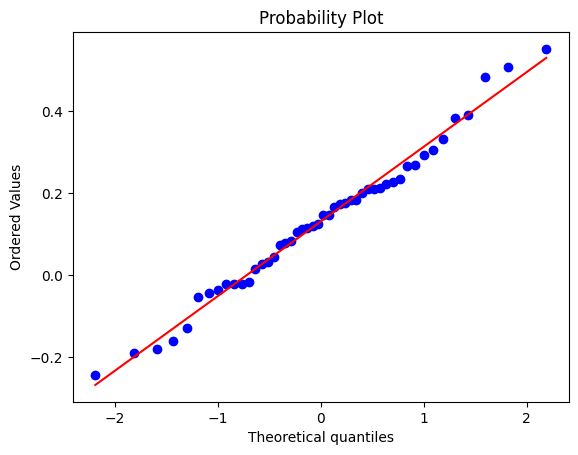

(array([  46.,  355.,  920., 1879., 2516., 2324., 1191.,  513.,  234.,
          22.]),
 array([-0.45845869, -0.33346682, -0.20847495, -0.08348308,  0.04150879,
         0.16650066,  0.29149253,  0.4164844 ,  0.54147627,  0.66646814,
         0.79146001]),
 <BarContainer object of 10 artists>)

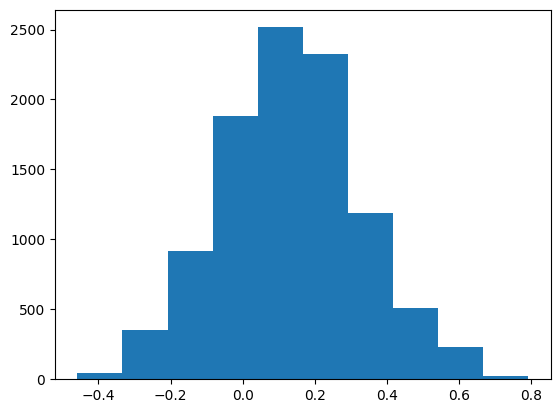

In [7]:
from scipy.stats import gaussian_kde
import scipy.stats as stats
import matplotlib.pyplot as plt

normal = data[(data['Year'] > 1990)]

kernelData = list(normal['OilChange']) + list(normal['GasChange']) + list(normal['DryChange'])

stats.probplot(kernelData,dist = "norm",plot = plt)

plt.show()

kernel = gaussian_kde(kernelData)

samp = kernel.resample(size = 10000).flatten();

plt.hist(samp)

Looking exceptionally normal! 
Probably safe to go with an assumed normal distribution

In [8]:
loc = pd.Series(kernelData).mean()
scale = np.sqrt(pd.Series(kernelData).var())

print(f"Normal Dist\nMu: {round(loc,3)} \nStddev: {round(scale,3)}")

Normal Dist
Mu: 0.131 
Stddev: 0.178


## Simulation Function
- k: By default False. If true, the kernel density will be used for 2006-2012 instead of the normal distribution
- Returns: Returns a simulated value of changes in cost from 2006 to 2025

In [ ]:
def drill(k = False):
    changes = []
    
    ## 2007-2012 Depending on k = 
    if k == True:
        samp = list(kernel.resample(size = 6).flatten());
    else:
        samp = list(np.random.normal(loc = loc,scale = scale,size = 6))
    changes += (samp)
    ## 2012 - 2015
    samp = list(np.random.triangular(right = -.07,mode = -.0917,left = -.22,size = 3))
    changes += samp
    ## 2015-2025
    samp = list(np.random.triangular(left = .02,mode = .05,right = .06,size = 10))
    changes += samp
    
    # Create the product of all the years changes 
    temp = pd.Series([1] * len(changes))
    changes = pd.Series(changes) + temp
    
    return changes.prod()
    


## Simulating

- Runs 1,000,000 Simulations for normal and kernel
- Saves them to a file 

In [10]:
price2006 = data.loc[len(data) - 1,"Drill"]
print(price2006)

2279.7999999999997


In [ ]:
import joblib as jl

simulationsNormal = []
for i in range(0,100000):
     a = simulate()
     simulationsNormal.append(a)


simulationsNormal = pd.Series(simulationsNormal) * price2006

jl.dump(simulationsNormal,"simulationsNormal.pkl")

simulationsKernel = []
for i in range(0,100000):
     a = simulate(k = True)
     simulationsKernel.append(a)

simulationsKernel = pd.Series(simulationsKernel) * price2006

jl.dump(simulationsKernel,"simulationsKernel.pkl")

## Simulation Graphs
- Normal and Kernel

In [20]:
import joblib as jl
# Read in the Files
simulationsKernel = jl.load("simulationsKernel.pkl")
simulationsNormal = jl.load("simulationsNormal.pkl")

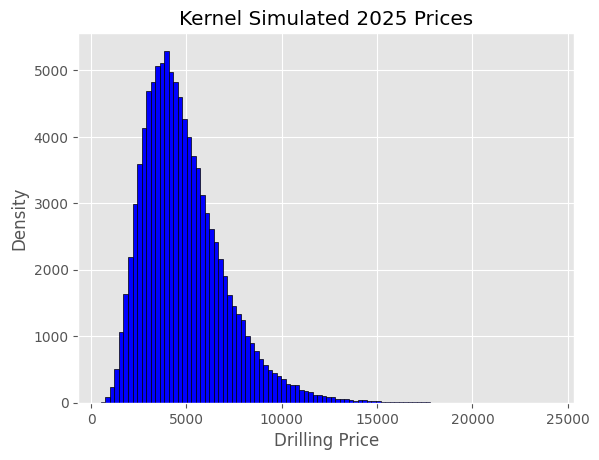

In [25]:
import matplotlib.ticker as mtick


plt.hist(pd.Series(simulationsKernel),edgecolor = "black",color = "blue",bins = 100)
plt.style.use("ggplot")
plt.xlabel("Drilling Price")
plt.ylabel("Density")
plt.title("Kernel Simulated 2025 Prices")
plt.show()

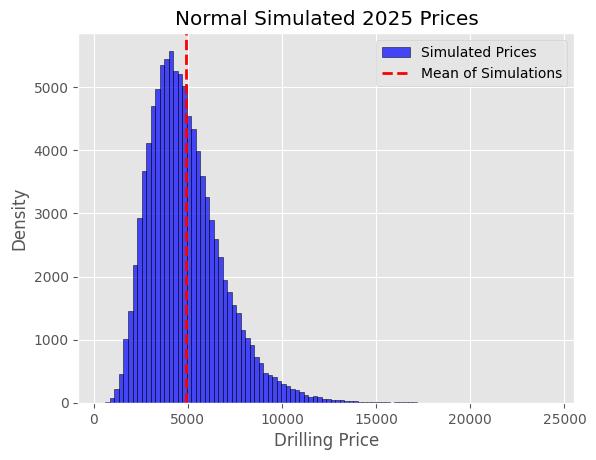

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

plt.hist(pd.Series(simulationsNormal), edgecolor="black", color="blue", bins=100, alpha=0.7, label="Simulated Prices")
plt.style.use("ggplot")
plt.xlabel("Drilling Price")
plt.ylabel("Density")
plt.title("Normal Simulated 2025 Prices")

mean_value = pd.Series(simulationsNormal).mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label="Mean of Simulations")

plt.legend()

plt.show()


In [15]:
(pd.Series(simulationsKernel)).describe()

count    100000.000000
mean       4861.572496
std        2155.483067
min         519.440823
25%        3311.032891
50%        4476.517752
75%        6001.345170
max       24161.019624
dtype: float64

In [21]:
(pd.Series(simulationsNormal)).describe()

count    100000.000000
mean       4874.937431
std        1977.832459
min         379.154574
25%        3451.933213
50%        4567.936595
75%        5948.413451
max       24334.004988
dtype: float64

In [19]:
pd.Series(simulationsNormal).quantile([0,.1,.2,.25,.5,.75,.90,1])

0.00      379.154574
0.10     2651.447781
0.20     3213.372988
0.25     3451.933213
0.50     4567.936595
0.75     5948.413451
0.90     7493.897333
1.00    24334.004988
dtype: float64

In [3]:
import spacy
spacy.load("en_core_web_sm")

In [44]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')
doc = nlp(u'I am not a fan of dogs. I hate your cat')

options = {'compact': True, 'color': 'black', 'font': 'Arial'}

# Corrected condition
negation_tokens = [tok for tok in doc if tok.dep_ == 'neg' or tok.text == "hate"]

negation_head_tokens = [token.head for token in negation_tokens]



for token in negation_head_tokens:
    print(token.text, token.dep_, token.head.text, token.head.pos_, [child.text for child in token.children])

# displacy.serve(doc, style='dep', options=options)


am ROOT am AUX ['I', 'not', 'fan', '.']
hate ROOT hate VERB ['I', 'cat']


In [43]:
negation_head_tokens

[am, hate, hate, hate]

In [28]:
negation = [tok for tok in doc if tok.dep_ == 'neg']

negation

[]

In [29]:
for token in doc:
    print(token.dep_)

nsubj
ROOT
dobj


In [ ]:
negation_tokens = [tok for tok in doc if tok.dep_ == 'neg' or tok.head == "hate"]




negation_head_tokens = [token.head for token in negation_tokens]

for token in negation_head_tokens:
     print(token.text, token.dep_, token.head.text, token.head.pos_, [child for child in token.children])

AttributeError: 'spacy.tokens.token.Token' object has no attribute 'astype'

In [48]:
[tok.text + "111" for tok in negation_head_tokens if tok.text == "hate"]

['hate111']